In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mwparserfromhell
import string
import vaderSentiment
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords

# Loading Data

And correct some date inconcistencies

In [3]:
# Read the file into a list of lines
with open('wiki-RfA.txt', 'r', encoding="utf8") as file:
    lines = file.readlines()

# Create a list of dictionaries, where each dictionary represents a record
df = []
current_entry = {}

# Iterate through each line, current_entry = one log entry with all columns, df = list of all votee/voter pairs
for line in lines:
    line = line.strip()
    if line:
        key, value = line.split(':', 1)
        current_entry[key] = value
    else:
        df.append(current_entry)
        current_entry = {}

# Append  last record
if current_entry:
    df.append(current_entry)

# Convert into DataFrame and store in csv
df = pd.DataFrame(df)
df.columns = ['Source', 'Target', 'Vote', 'Results', 'Year', 'Date', 'Comment']
original_df = df.copy()
df.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment
12533,Reedy,HJ Mitchell,-1,1,2011,"22:38, 8 May 2011",'''Oppose'''
13217,Kwamikagami,Kudpung,-1,1,2011,"07:06, 25 February 2011",'''Oppose''' One of the most unpleasant and se...
13048,Trusilver,Ks0stm,1,1,2011,"07:19, 9 September 2011",'''Support''' moved from Oppose. I have some r...


In [4]:
# Set Nan values
# replace field that's entirely space (or empty) with NaN (the case for some Source, Date and Comment)
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#handle NaN values in Comment for vectorization
df.Comment = df.Comment.replace(np.nan, None)

# replace inconsistent date
df['Date'] = df['Date'].str.replace('Julu ', 'July ')
df['Date'] = df['Date'].str.replace('Janry ', 'January ')
df['Date'] = df['Date'].str.replace('Mya ', 'May ')
df['Date'] = df['Date'].str.replace('Jan ', 'January ')
df['Date'] = df['Date'].str.replace('Feb ', 'February ')
df['Date'] = df['Date'].str.replace('Mar ', 'March ')
df['Date'] = df['Date'].str.replace('Apr ', 'April ')
df['Date'] = df['Date'].str.replace('Jun ', 'June ')
df['Date'] = df['Date'].str.replace('Jul ', 'July ')
df['Date'] = df['Date'].str.replace('Aug ', 'August ')
df['Date'] = df['Date'].str.replace('Sep ', 'September ')
df['Date'] = df['Date'].str.replace('Oct ', 'October ')
df['Date'] = df['Date'].str.replace('Nov ', 'November ')
df['Date'] = df['Date'].str.replace('Dec ', 'December ')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%H:%M, %d %B %Y', errors='coerce')

# Convert Year to int
df['Year'] = df['Year'].astype(int)

df.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment
75735,Hro%C3%B0ulf,Golich17,-1,-1,2008,2008-06-23 10:54:00,'''Oppose with regret''': An outstanding edito...
180171,Suffice,Mark Dingemanse,1,1,2005,2005-03-14 02:15:00,'''Support'''. [[Image:Cheeseburger.png|20px]]
29279,BD2412,Jc3s5h,1,-1,2010,2010-08-14 00:49:00,'''Support''' per nom.


In [5]:
# Select users with a significant number of duplicates (by manually checking the data we found that 6 discriminate perfectly between users with actual duplicates and users with only missing data or basic comments)
users_with_duplicates = df[df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False) & df.Source.notnull()].groupby('Target').size() >= 6
users_with_duplicates = users_with_duplicates[users_with_duplicates].index
duplicates = df[df.Target.isin(users_with_duplicates) & df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False) & df.Source.notnull()].sort_values(by=['Target', 'Source', 'Date'])
#Remove the data of to_remove from df
df = df.drop(duplicates.index)


# Deal with duplicates that have different results 
perc_vote = (duplicates.groupby(['Target', 'Year']).Vote.value_counts(normalize=True) * 100).unstack(level='Vote')
perc_vote['Result'] = perc_vote.apply(lambda x: 1 if x['1'] >= 70 else -1, axis=1, result_type='reduce')
# Replace results in duplicates with results in perc_vote
duplicates['Results'] = duplicates.apply(lambda x: perc_vote.loc[(x['Target'], x['Year'])]['Result'].astype(int), axis=1)


# Deal with duplicates that have different years
correct_year = pd.DataFrame({'Year': duplicates.Date.dt.year, 'Target': duplicates.Target})
# Replace nan values in Year with most common year for each Target (some Dates are missing)
correct_year.Year = correct_year.groupby('Target').Year.transform(lambda x: x.fillna(x.mode()[0]))
# Replace years in duplicates with years in correct_year
duplicates = duplicates.drop(columns='Year').join(correct_year.Year)

# Drop the duplicate rows 
duplicates.drop_duplicates(keep='first', inplace=True)
# Add the duplicates to df
df = pd.concat([df, duplicates]).sort_index()


# Deal with duplicates that have different Vote
double_vote = df[df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False) & df.Source.notnull() & df.Date.notnull() & (df.Vote == '0')]
# Drop the double_vote rows
df.drop(double_vote.index, inplace=True)

df.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment
47753,MichaelQSchmidt,HJ Mitchell,1,-1,2009.0,2009-12-26 03:39:00,Has my '''Support'''. In crossing pages with h...
18030,Timotheus Canens,Slon02,1,-1,2011.0,2011-03-05 15:34:00,I'm not concerned about nitpicking about hyper...
54780,Siva1979,Alexf,1,1,2008.0,2008-01-20 12:08:00,'''Support''' No problems here. --<font style=...


## Tests sentiment analysis

In [6]:
# Libraries
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

In [11]:
#Parse the comments to a new column
df_comment = pd.read_csv('wiki-RfA.csv', index_col=0, parse_dates=['Date'])

df_comment['Comment'] = df_comment['Comment'].apply(lambda x: [] if pd.isna(x) else x)
df_comment["Parsed_Comment"] = df_comment.Comment.apply(lambda x: mwparserfromhell.parse(x).strip_code())

#Initialize a dataframe containing only relevant info for futur comment analysis
stat_df = pd.DataFrame(columns = ['Source','Vote', 'Comment', 'Parsed_Comment'])
stat_df['Vote']=df_comment['Vote']
stat_df['Source']=df_comment['Source']
stat_df['Comment'] = df_comment['Comment']
stat_df['Parsed_Comment']=df_comment['Parsed_Comment']

In [16]:
#df_comment['Comment']
df_comment["Parsed_Comment"]

0                                        Support as co-nom.
1                                   Support as nominator.--
2                                         Support per noms.
3         Support per noms. BDD is a strong contributor ...
4         Support, with great pleasure. I work with BDD ...
                                ...                        
198270                                              Support
198271                                             Support.
198272                                          Support. --
198273    Support.  Age has nothing to do with maturity....
198274    Support - anyone who can write so much, and so...
Name: Parsed_Comment, Length: 195647, dtype: object

In [18]:
import en_core_web_sm
nlp = spacy.load("en_core_web_sm")

doc = nlp(df_comment["Parsed_Comment"][0])

#strings are encoded to hashes
tokens = [token.text for token in doc]

print(df_comment["Parsed_Comment"][0],'\n')
print(tokens)

Support as co-nom. 

['Support', 'as', 'co', '-', 'nom', '.']


In [20]:
analyzer = SentimentIntensityAnalyzer()
vs = analyzer.polarity_scores(df_comment["Parsed_Comment"][0])

In [21]:
print(df_comment["Parsed_Comment"][0], '\n')
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'])

Support as co-nom. 

Negative sentiment: 0.0
Neutral sentiment: 0.426
Positive sentiment: 0.574
Compound sentiment: 0.4019


In [36]:
doc = df_comment["Parsed_Comment"]
doc.shape

(195647,)

Text(0, 0.5, 'Number of comments')

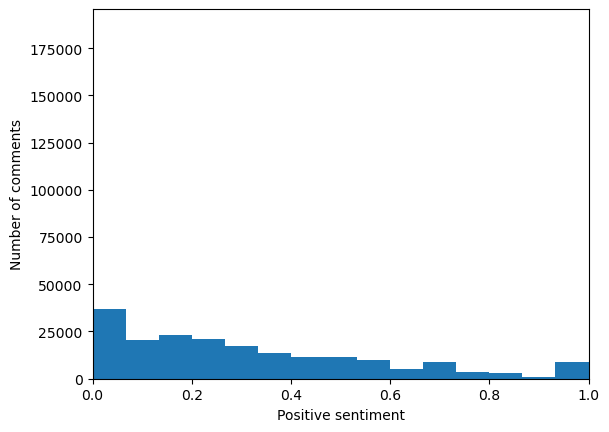

In [29]:
positive_sent = []
#iterate through the sentences, get polarity scores, choose a value
[positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in doc]
plt.hist(positive_sent,bins=15)
plt.xlim([0,1])
plt.ylim([0,195647])
plt.xlabel('Positive sentiment')
plt.ylabel('Number of comments')

In [35]:
len(positive_sent)

195647

Text(0, 0.5, 'Number of comments')

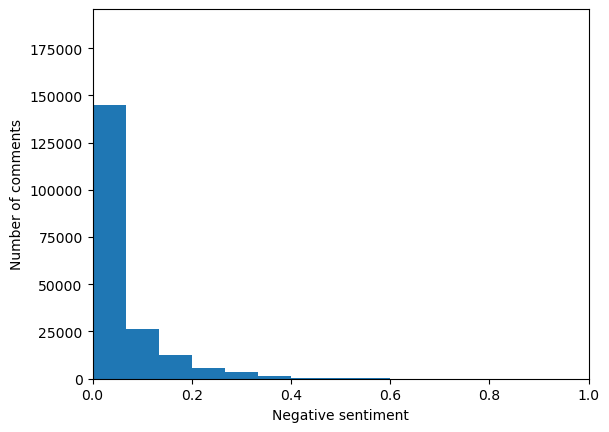

In [37]:
negative_sent = []
#iterate through the sentences, get polarity scores, choose a value
[negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in doc]
plt.hist(negative_sent,bins=15)
plt.xlim([0,1])
plt.ylim([0,195647])
plt.xlabel('Negative sentiment')
plt.ylabel('Number of comments')

Text(0, 0.5, 'Number of comments')

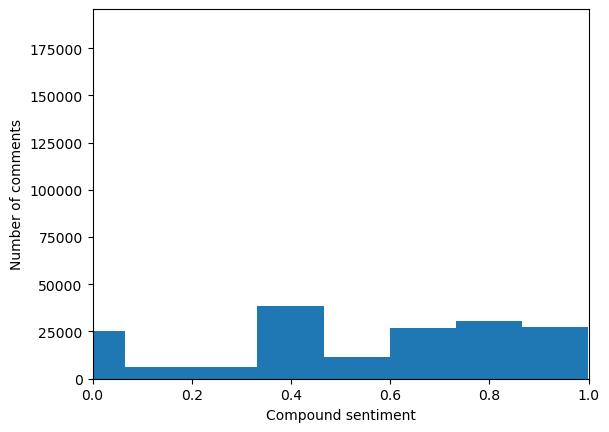

In [39]:
total_sent = []
#iterate through the sentences, get polarity scores, choose a value
[total_sent.append(analyzer.polarity_scores(sent)['compound']) for sent in doc]
plt.hist(total_sent,bins=15)
plt.xlim([0,1])
plt.ylim([0,195647])
plt.xlabel('Compound sentiment')
plt.ylabel('Number of comments')

In [41]:
sents = [analyzer.polarity_scores(sent)['compound'] for sent in doc]
print('Number of positive sentences:',sum(np.array(sents)>=0.05))
print('Number of negative sentences:',sum(np.array(sents)<=-0.05))
print('Number of neutral sentences:',sum(np.abs(np.array(sents))<0.05))

Number of positive sentences: 147934
Number of negative sentences: 24062
Number of neutral sentences: 23651


In [61]:
print("Nombre de commentaires :", len(sents))

doc_copy = doc.copy().to_frame()
print(type(doc_copy))
doc_copy["sent_score"] = sents
doc_copy

Nombre de commentaires : 195647
<class 'pandas.core.frame.DataFrame'>


,Parsed_Comment,sent_score
0,Support as co-nom.,0.4019
1,Support as nominator.--,0.4019
2,Support per noms.,0.4019
3,Support per noms. BDD is a strong contributor ...,0.7052
4,"Support, with great pleasure. I work with BDD ...",0.9349
...,...,...
198270,Support,0.4019
198271,Support.,0.4019
198272,Support. --,0.4019
198273,Support. Age has nothing to do with maturity....,0.4019


# Remarque : Il semble y avoir plusieurs valeurs à 0.4019 pour une raison quelconque..